In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from geometry_msgs.msg import PoseStamped
import math
import random as rand
import numpy as np
from numpy.linalg import norm
from math import *
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time
from PIL import Image
import cv2 
from nav_msgs.msg import Path
from scipy import interpolate

Map and Map metadata

In [2]:
im = Image.open("/home/scifiswapnil/Desktop/jackal_ws/src/jackal_sim/map/stage_one.pgm")
map_grid = np.asarray(im)
map_grid = np.where(map_grid==205, 0, map_grid)
map_grid = np.where(map_grid>=250, 255, map_grid)
ret,thresh1 = cv2.threshold(map_grid,127,255,cv2.THRESH_BINARY)
map_grid = np.invert(thresh1)
# kernel = np.ones((120,120),np.uint8)
# map_grid = cv2.dilate(map_grid,kernel,iterations = 1)
map_grid = np.invert(map_grid)

map_x = 4992 # in pixels
map_y = 4992 # in pixels
map_res = 0.01 # in meters

cv2.imshow("map_grid", cv2.resize(map_grid, (600,600)))
cv2.waitKey(0)
cv2.destroyAllWindows()

# print("------------------------")
# print("pixel space x = ",map_x)
# print("pixel space y = ",map_y)
# print("pixel space resolution = ",map_res,"meters per pixel")
# print("pixel space origin = 0,0 (bottom left corner)")
# print("------------------------")
# print("in mtrs real world min x = ",-((map_x*map_res))/2)
# print("in mtrs real world max x = ",((map_x*map_res))/2)
# print("in mtrs real world min y = ",-((map_y*map_res))/2)
# print("in mtrs real world max y = ",((map_y*map_res))/2)
# print("------------------------")

Helper Functions

In [3]:
def meters2grid(pose_m):
    if np.isscalar(pose_m):
        pose_on_grid = int( pose_m/ map_res + (map_x/2) )
    else:
        pose_on_grid = np.array( np.array([(map_x/2),(map_x/2)]) + np.array(pose_m)/ map_res, dtype=int)
        pose_on_grid[1] = -pose_on_grid[1] + map_x
    return pose_on_grid

def grid2meters(pose_grid):
    if np.isscalar(pose_grid):
        pose_meters = (pose_grid* map_res + -24.96)
    else:
        pose_meters = ( np.array(pose_grid)* map_res + np.array([-24.96, -24.96]) )
        pose_meters[:,1] = -pose_meters[:,1]
    return pose_meters

RRT path planner

In [4]:
class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    def __init__(self,
                 start,
                 goal,
                 map_grid,
                 rand_area,
                 expand_dis=10,
                 path_resolution=10,
                 goal_sample_rate=5,
                 max_iter=5900):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate#
        self.grid_map = map_grid
        self.max_iter = max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node,self.grid_map):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node,self.grid_map):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if rand.randint(0, 10) > self.goal_sample_rate:
            rnd = self.Node(
                int(rand.uniform(self.min_rand, self.max_rand)),
                int(rand.uniform(self.min_rand, self.max_rand)))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")
        plt.imshow(self.grid_map)
        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([0, 5000,5000,0])
        plt.grid(True)
        plt.pause(0.0001)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node,grid_map):
        if node is None:
            return False
        if (grid_map[int(node.y),int(node.x)] != 0.0):
            return True
        else:
            return False


    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

ROS Code

[INFO] [1625490630.265135, 315.157000]: Got the map


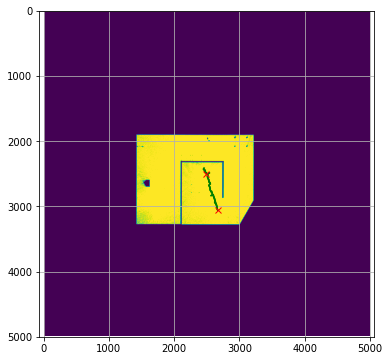

found path!!


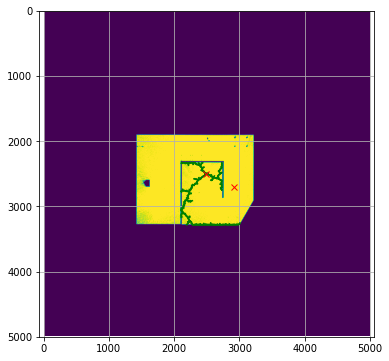

Cannot find path


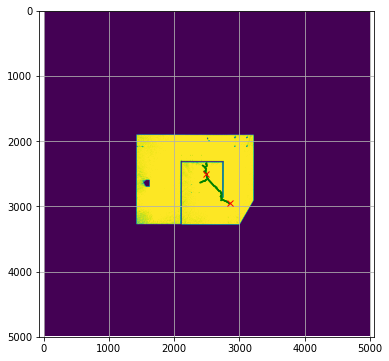

found path!!


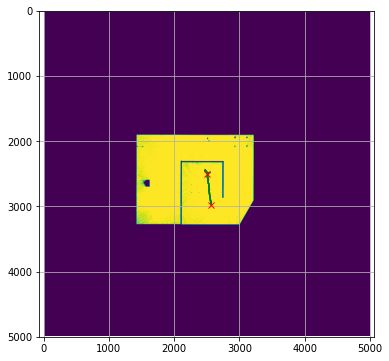

found path!!


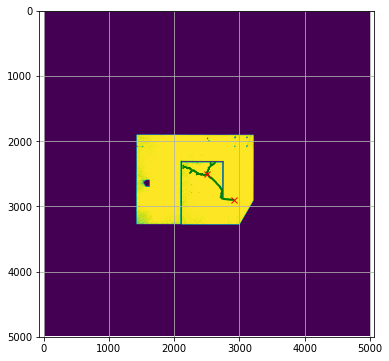

found path!!


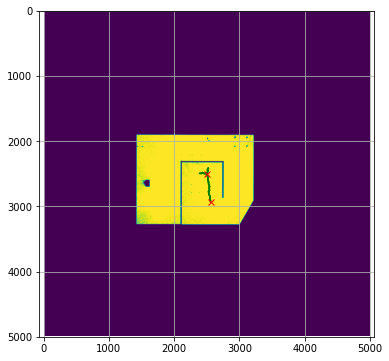

found path!!


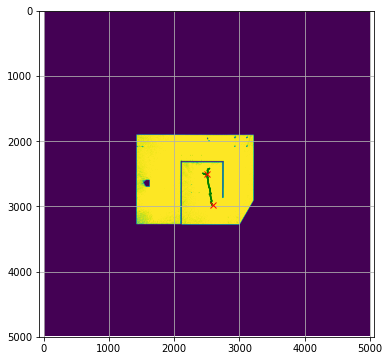

found path!!


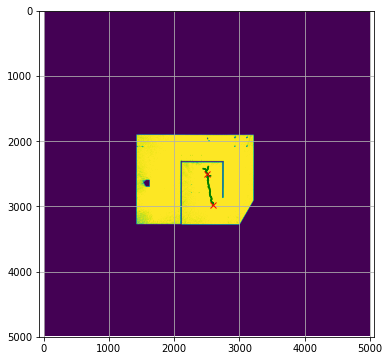

found path!!


In [5]:
import rospy
from nav_msgs.msg import OccupancyGrid
from geometry_msgs.msg import PoseStamped
from nav_msgs.msg import Odometry

odata = None
xy_start = None
xy_goal = None
rrtpath_pub = None
path_pub = None


def callback(data):
    global odata
    odata = data
    rospy.loginfo("Got the map")

def callbackodom(data):
    global xy_start
    xy_start = meters2grid((data.pose.pose.position.x, data.pose.pose.position.y))

    
def callbackgoal(data):
    global xy_goal
    global xy_start
    global path_pub
    xy_goal = meters2grid((data.pose.position.x, data.pose.position.y))
    plt.figure(figsize=(6,6))
    plt.grid()
    plt.imshow(map_grid)
    plt.plot(xy_start[0],xy_start[1],'bo', markersize=5, label='start')
    plt.plot(xy_goal[0],xy_goal[1],'go', markersize=5, label='goal')
    plt.xlabel('X, m')
    plt.ylabel('Y, m')
    plt.legend()
    rrt = RRT(
        start=[xy_start[0],xy_start[1]],
        goal=[xy_goal[0],xy_goal[1]],
        rand_area=[0, 4990],
        map_grid=map_grid,
        expand_dis=11,
        path_resolution=10,
        goal_sample_rate=5,
        max_iter=10000)
    path = rrt.planning(animation=False)
    rrt.draw_graph()
    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")
        rrp = grid2meters((path[2:]))
        f, u = interpolate.splprep([rrp[:,0], rrp[:,1]],s=0.1)
        xsmooth, ysmooth = interpolate.splev(np.linspace(0, 1, 200), f)
        ros_path = np.vstack((xsmooth,ysmooth))
#         rrtpath = Path()
#         rrtpath.header.frame_id = "map"
#         rrtpath.header.stamp = rospy.Time.now()
        rrtsmoothpath = Path()
        rrtsmoothpath.header.frame_id = "map"
        rrtsmoothpath.header.stamp = rospy.Time.now()
        for i in range(len(ros_path[0,:])):
            pose = PoseStamped()
            pose.header = rrtsmoothpath.header
            pose.pose.position.x = ros_path[0,i]
            pose.pose.position.y = ros_path[1,i]
            pose.pose.orientation.w = 1
            rrtsmoothpath.poses.append(pose)
        path_pub.publish(rrtsmoothpath)
#         for i in range(len(rrp)):
#             pose = PoseStamped()
#             pose.header = rrtpath.header
#             pose.pose.position.x = rrp[i][0]
#             pose.pose.position.y = rrp[i][1]
#             pose.pose.orientation.w = 1
#             rrtpath.poses.append(pose)
#         rrtpath_pub.publish(rrtpath)

rospy.init_node('listener', anonymous=True)
rospy.Subscriber("/map", OccupancyGrid, callback)
rospy.Subscriber("/move_base_simple/goal", PoseStamped, callbackgoal)
rospy.Subscriber("/odometry/filtered", Odometry, callbackodom)
rrtpath_pub = rospy.Publisher('/rrtpath', Path, queue_size=10)
path_pub = rospy.Publisher('/path', Path, queue_size=10)

In [ ]:
# plt.scatter(rrp[:,0], rrp[:,1])
# plt.plot(xint, yint)
# plt.show()
# plt.plot([x for (x, y) in ros_path], [y for (x, y) in ros_path], '-r')
# plt.grid(True)
# plt.show()